## Normal sleep patterns attenuates the associations of systemic immune-inflammation index with total and cause-specific mortality among middle-aged and older populations: Evidence from NHANES 1999 - 2012 using NHANES-GCP.

## Study population

**71916** participants enrolled in the NHANES 1999 - 2012.

**24789** participants who aged 40 or over at the baseline

- Subjects who didn't receive physical examination (n = 1380)
- Subjects without mortality data (n = 34 )
- Subjects missing SII value at basline (n = 2564 )

Study population (N = **20811**)
- Endpoint December 2013

## Conclusion

Our studies found that high levels of SII were associated with a higher risk of total mortality  **[ HR (95% CI) = 1.15(1.07 - 1.22) ]**, and a marginally increased risk of CVD mortality **[ HR (95% CI) = 1.08(0.96 - 1.22) ]**, cancer mortality **[ HR (95% CI) = 0.97(0.86 - 1.10) ]**, and other causes of mortality  **[ HR (95% CI) =1.06(0.94 - 1.20)]**. For subjects with a high level of SII, the absence of a sleep disorder could attenuate **22%** risk of total mortality in the NHANES 1999–2012.

In [1]:
! pip install pandas google-cloud-bigquery lifelines db-dtypes

In [3]:
import os
import pandas as pd
from lifelines import CoxPHFitter
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery

In [350]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "nhanesgcp-cb4c8ab27256.json"
client = bigquery.Client()

In [483]:
query = """
WITH MortalityData AS (
    SELECT
        respondent_sequence_number,
        CASE
            WHEN ucod_leading = 1.0 THEN 'Diseases of heart'
            WHEN ucod_leading = 2.0 THEN 'Malignant neoplasms'
            WHEN ucod_leading = 3.0 THEN 'Chronic lower respiratory diseases'
            WHEN ucod_leading = 4.0 THEN 'Accidents (unintentional injuries)'
            WHEN ucod_leading = 5.0 THEN 'Cerebrovascular disease'
            WHEN ucod_leading = 6.0 THEN 'Alzheimer’s disease'
            WHEN ucod_leading = 7.0 THEN 'Diabetes mellitus'
            WHEN ucod_leading = 8.0 THEN 'Influenza and pneumonia'
            WHEN ucod_leading = 9.0 THEN 'Nephritis, nephrotic syndrome and nephrosis'
            WHEN ucod_leading = 10.0 THEN 'All other causes (residual)'
            ELSE 'Unknown cause'
        END AS ucod_leading,
        mort_stat,
        permth_exm
    FROM
        `nhanesgcp.nhanes_mort_1999_2018.nhanes_mort`
),
Have_Diabetes AS (
    SELECT 
        respondent_sequence_number,
        doctor_told_you_have_diabetes 
    FROM 
        `nhanesgcp.dbt.diabetes_questionnaire` WHERE doctor_told_you_have_diabetes = "Yes"
),
Sleep AS (
   SELECT 
       respondent_sequence_number,
       COALESCE(ever_told_by_doctor_have_sleep_disorder, "No") AS sleep_disorder
    FROM 
        `nhanesgcp.dbt.sleep_disorders_questionnaire` 
    WHERE ever_told_by_doctor_have_sleep_disorder IS NOT NULL
),
SII_Calculation AS (
    SELECT 
        respondent_sequence_number,
        segmented_neutrophils_num_1000_cell_ul,
        segmented_neutrophils_num_1000_cell_ul,
        lymphocyte_number_1000_cells_ul,
        (segmented_neutrophils_num_1000_cell_ul * platelet_count_1000_cells_ul) / lymphocyte_number_1000_cells_ul AS SII
    FROM 
        `nhanesgcp.dbt.complete_blood_count_with_5_part_differential_whole_blood_laboratory`
),
SII_Stats AS (
    SELECT
        APPROX_QUANTILES(SII, 4) AS quartiles
    FROM
        SII_Calculation
),
SII_Groups AS (
    SELECT
        SII_Calculation.*,
        CASE
            WHEN SII IS NULL THEN NULL
            WHEN SII <= (SELECT quartiles[OFFSET(1)] FROM SII_Stats) THEN 'Low'
            WHEN SII <= (SELECT quartiles[OFFSET(2)] FROM SII_Stats) THEN 'Middle'
            ELSE 'High'
        END AS SII_Group
    FROM
        SII_Calculation
    CROSS JOIN
        SII_Stats
),
PhysicalActivityData AS (
    SELECT
        respondent_sequence_number,
        COALESCE(of_times_did_activity_in_past_30_days * average_duration_of_activity_minutes, 0) AS total_activity_duration_minutes
    FROM
       `nhanesgcp.dbt.physical_activity_individual_activities_questionnaire`
),
BodyMeasurements AS (
    SELECT 
        respondent_sequence_number,
        weight_kg,
        standing_height_cm,
        COALESCE(weight_kg / (standing_height_cm / 100), 0) AS bmi
    FROM 
        `nhanesgcp.dbt.body_measures_examination`
),
AlcoholData AS (
    SELECT
        respondent_sequence_number,
        had_at_least_12_alcohol_drinks_1_yr
    FROM
        `nhanesgcp.dbt.alcohol_use_questionnaire`
),
AlcoholDrinkingStatus AS (
    SELECT
        respondent_sequence_number,
        CASE
            WHEN COALESCE(had_at_least_12_alcohol_drinks_1_yr, 'No') = 'Yes' THEN 'Drinker'
            ELSE 'Non-Drinker'
        END AS alcohol_drinking_status
    FROM
        AlcoholData
),
 SmokingData AS (
    SELECT
        respondent_sequence_number,
        smoked_at_least_100_cigarettes_in_life
    FROM
        `nhanesgcp.dbt.smoking_cigarette_use_questionnaire`
),
SmokingStatus AS (
    SELECT
        respondent_sequence_number,
        CASE
            WHEN COALESCE(smoked_at_least_100_cigarettes_in_life, 'No') = 'Yes' THEN 'Smoker'
            ELSE 'Non-Smoker'
        END AS smoking_status
    FROM
        SmokingData
),
Filtered_Demographics AS (
    SELECT 
        respondent_sequence_number,
        age_in_years_at_screening AS age,
        interview_examination_status,
        gender,
        race_hispanic_origin AS race,
        CASE
    WHEN COALESCE(education_recode_old_version, 'Less Than High School') = 'More Than High School' THEN 'college or above'
    WHEN COALESCE(education_recode_old_version, 'Less Than High School') = 'High School Diploma (including GED)' THEN 'high school'
    ELSE 'Less Than High School'
END AS education_level
    FROM 
        `nhanesgcp.dbt.demographic_variables_sample_weights_demographics`
    WHERE 
        end_year <= 2015
        AND 
        CAST(age_in_years_at_screening AS INT64) >= 40
)
SELECT 
    fd.respondent_sequence_number,
    fd.age,
    fd.gender,
    bm.bmi,
    fd.race,
    fd.education_level,
    ads.alcohol_drinking_status,
    CASE
        
        WHEN ss.smoking_status = "Smoker" THEN "Smoker"
        ELSE "Non-smoker"
    END AS smoking_status,
    
    md.ucod_leading,
    md.mort_stat,
    md.permth_exm,
    sii.SII,
    # CASE 
    #     WHEN slp.sleep_hours_weekdays_or_workdays >= 6 THEN 'Quality Sleep'
    #     ELSE 'Inadequate Sleep'
    # END AS sleep_classification,
    
    slp.sleep_disorder,
    
    CASE 
        WHEN pa.total_activity_duration_minutes >= 150 THEN 'Physically Active'
        ELSE 'Physically Inactive'
    END AS physical_activity_classification,
        sg.SII_Group
    FROM 
        Filtered_Demographics fd
    LEFT JOIN
        MortalityData md ON fd.respondent_sequence_number = md.respondent_sequence_number
    LEFT JOIN 
        SII_Calculation sii ON fd.respondent_sequence_number = sii.respondent_sequence_number
    LEFT JOIN
        PhysicalActivityData pa ON fd.respondent_sequence_number = pa.respondent_sequence_number
    LEFT JOIN 
        BodyMeasurements bm ON fd.respondent_sequence_number = bm.respondent_sequence_number
    LEFT JOIN 
        AlcoholData alcohol ON fd.respondent_sequence_number = alcohol.respondent_sequence_number
    LEFT JOIN 
        AlcoholDrinkingStatus ads ON fd.respondent_sequence_number = ads.respondent_sequence_number
    LEFT JOIN 
        SmokingData smoking ON fd.respondent_sequence_number = smoking.respondent_sequence_number
    LEFT JOIN 
        SmokingStatus ss ON fd.respondent_sequence_number = ss.respondent_sequence_number
    LEFT JOIN
        SII_Groups sg ON fd.respondent_sequence_number = sg.respondent_sequence_number
    LEFT JOIN
        Sleep slp ON fd.respondent_sequence_number = slp.respondent_sequence_number
     WHERE  
      md.mort_stat IS NOT NULL
      AND fd.interview_examination_status = "Both interviewed and MEC examined"
      AND sii.SII IS NOT NULL
    ORDER BY
        fd.respondent_sequence_number;
"""

In [484]:
df = client.query(query).to_dataframe()

In [485]:
df

,respondent_sequence_number,age,gender,bmi,race,education_level,alcohol_drinking_status,smoking_status,ucod_leading,mort_stat,permth_exm,SII,sleep_disorder,physical_activity_classification,SII_Group
0,2,77.0,Male,43.333333,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Alzheimer’s disease,1,177,682.125000,None,Physically Inactive,High
1,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500000,None,Physically Active,Low
2,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500000,None,Physically Active,Low
3,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500000,None,Physically Inactive,Low
4,5,49.0,Male,51.878856,Non-Hispanic White,college or above,Non-Drinker,Non-smoker,Unknown cause,0,244,294.500000,None,Physically Inactive,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28566,71902,67.0,Female,58.743169,Other Race - Including Multi-Racial,Less Than High School,Drinker,Non-smoker,Diseases of heart,1,94,733.700000,No,Physically Inactive,High
28567,71907,80.0,Male,40.763968,Non-Hispanic White,Less Than High School,Drinker,Non-smoker,Accidents (unintentional injuries),1,84,291.214286,No,Physically Inactive,Low
28568,71908,66.0,Female,55.786164,Non-Hispanic White,Less Than High School,Non-Drinker,Non-smoker,Unknown cause,0,103,352.444444,No,Physically Inactive,Middle
28569,71912,40.0,Male,49.520587,Non-Hispanic White,Less Than High School,Drinker,Smoker,Unknown cause,0,95,617.615385,No,Physically Inactive,High


In [486]:
df.describe()

,respondent_sequence_number,age,bmi,mort_stat,permth_exm,SII
count,28571.0,28571.000000,28571.000000,28571.0,28571.0,28571.000000
mean,34538.183158,59.245074,47.251253,0.279199,147.510973,575.400714
std,20128.46363,12.931661,12.678782,0.448613,58.353083,413.516265
min,2.0,40.000000,0.000000,0.0,0.0,1.528604
25%,17439.0,48.000000,40.550935,0.0,106.0,353.844130
50%,33730.0,58.000000,46.666667,0.0,150.0,495.000000
75%,51448.0,70.000000,53.582888,1.0,195.0,694.285714
max,71915.0,85.000000,219.786730,1.0,249.0,28397.275862


In [487]:
import numpy as np

def format_iqr(iqr):
    return f"({iqr[0]} - {iqr[1]})"

def summary_statistics(df, variable, category=False):
    """
    Generate summary statistics for a given variable in the DataFrame.

    Parameters:
    df (DataFrame): The pandas DataFrame containing the data.
    variable (str): The name of the variable/column for which summary statistics are calculated.
    category (bool): If True, the variable is treated as categorical. Default is False.

    Returns:
    dict: A dictionary containing summary statistics.
    """

    summary = {}
    data = df[variable]

    
    if not category:
        participants = (np.nanmedian(data), format_iqr((np.percentile(data, 25), np.percentile(data, 75))))
        survivors = (np.nanmedian(data[df['mort_stat'] == 0]), format_iqr((np.percentile(data[df['mort_stat'] == 0], 25), np.percentile(data[df['mort_stat'] == 0], 75))))
        deaths = (np.nanmedian(data[df['mort_stat'] == 1]), format_iqr((np.percentile(data[df['mort_stat'] == 1], 25), np.percentile(data[df['mort_stat'] == 1], 75))))
        summary['Participants'] = participants
        summary['Survivors'] = survivors
        summary['Deaths'] = deaths

   
    else:
        counts = data.value_counts()
        total = len(data)
        summary['Counts'] = counts.to_dict()
        summary['Percentages'] = {k: (v / total) * 100 for k, v in counts.items()}
        summary['Participants'] = (total, 100)
        summary['Deaths'] = (df[df['mort_stat'] == 1][variable].value_counts()).to_dict()
        summary['Survivors'] = (df[df['mort_stat'] == 0][variable].value_counts()).to_dict()

    return summary


variables = ['mort_stat','sleep_disorder','SII_Group','age', 'bmi', 'gender', 'race', 'education_level', 'alcohol_drinking_status', 'smoking_status', 'physical_activity_classification', 'ucod_leading']
for var in variables:
    if var in ['age', 'bmi']:
        print("Summary statistics for continuous variable:", var)
        print(summary_statistics(df, var))
    else:
        print("Summary statistics for categorical variable:", var)
        print(summary_statistics(df, var, category=True))


Summary statistics for categorical variable: mort_stat
{'Counts': {0: 20594, 1: 7977}, 'Percentages': {0: 72.08008120121802, 1: 27.919918798781985}, 'Participants': (28571, 100), 'Deaths': {1: 7977}, 'Survivors': {0: 20594}}
Summary statistics for categorical variable: sleep_disorder
{'Counts': {'No': 13940, 'Yes': 1434, 'Dont know': 19, 'Refused': 1}, 'Percentages': {'No': 48.790731860977914, 'Yes': 5.019075286129292, 'Dont know': 0.06650099751496272, 'Refused': 0.0035000525007875117}, 'Participants': (28571, 100), 'Deaths': {'No': 2925, 'Yes': 337, 'Dont know': 2, 'Refused': 1}, 'Survivors': {'No': 11015, 'Yes': 1097, 'Dont know': 17}}
Summary statistics for categorical variable: SII_Group
{'Counts': {'High': 16960, 'Middle': 6795, 'Low': 4816}, 'Percentages': {'High': 59.3608904133562, 'Middle': 23.782856742851145, 'Low': 16.856252843792657}, 'Participants': (28571, 100), 'Deaths': {'High': 5149, 'Middle': 1592, 'Low': 1236}, 'Survivors': {'High': 11811, 'Middle': 5203, 'Low': 3580}

In [488]:

low_group = df[df['SII_Group'] == 'Low']
middle_group = df[df['SII_Group'] == 'Middle']
high_group = df[df['SII_Group'] == 'High']


low_range = (low_group['SII'].min(), low_group['SII'].max())
middle_range = (middle_group['SII'].min(), middle_group['SII'].max())
high_range = (high_group['SII'].min(), high_group['SII'].max())


print("Range for Low group:", low_range)
print("Range for Middle group:", middle_range)
print("Range for High group:", high_range)


Range for Low group: (1.5286041189931348, 304.0)
Range for Middle group: (304.00000000000006, 440.7)
Range for High group: (440.75, 28397.275862068964)


In [489]:

def calculate_counts_deaths(data):
    total_count = len(data)
    total_deaths = np.sum(data['mort_stat'] == 1)
    cvd_deaths = np.sum(data[data['ucod_leading'] == 'Diseases of heart']['mort_stat'] == 1)
    cancer_deaths = np.sum(data[data['ucod_leading'] == 'Malignant neoplasms']['mort_stat'] == 1)
    other_deaths = total_deaths - cvd_deaths - cancer_deaths
    return total_count, total_deaths, cvd_deaths, cancer_deaths, other_deaths


low_group = df[df['SII_Group'] == 'Low']
middle_group = df[df['SII_Group'] == 'Middle']
high_group = df[df['SII_Group'] == 'High']


low_counts, low_deaths, low_cvd_deaths, low_cancer_deaths, low_other_deaths = calculate_counts_deaths(low_group)
middle_counts, middle_deaths, middle_cvd_deaths, middle_cancer_deaths, middle_other_deaths = calculate_counts_deaths(middle_group)
high_counts, high_deaths, high_cvd_deaths, high_cancer_deaths, high_other_deaths = calculate_counts_deaths(high_group)


print("Low SII Level:")
print("Total Count:", low_counts)
print("Total Deaths:", low_deaths)
print("CVD Deaths:", low_cvd_deaths)
print("Cancer Deaths:", low_cancer_deaths)
print("Other Deaths:", low_other_deaths)
print()

print("Middle SII Level:")
print("Total Count:", middle_counts)
print("Total Deaths:", middle_deaths)
print("CVD Deaths:", middle_cvd_deaths)
print("Cancer Deaths:", middle_cancer_deaths)
print("Other Deaths:", middle_other_deaths)
print()

print("High SII Level:")
print("Total Count:", high_counts)
print("Total Deaths:", high_deaths)
print("CVD Deaths:", high_cvd_deaths)
print("Cancer Deaths:", high_cancer_deaths)
print("Other Deaths:", high_other_deaths)


Low SII Level:
Total Count: 4816
Total Deaths: 1236
CVD Deaths: 272
Cancer Deaths: 321
Other Deaths: 643

Middle SII Level:
Total Count: 6795
Total Deaths: 1592
CVD Deaths: 437
Cancer Deaths: 380
Other Deaths: 775

High SII Level:
Total Count: 16960
Total Deaths: 5149
CVD Deaths: 1336
Cancer Deaths: 1124
Other Deaths: 2689


In [491]:
data =  df


df['SII_Group'] = pd.Categorical(df['SII_Group'], categories=['Low', 'Middle', 'High'], ordered=True)


df['physical_activity_classification'] = pd.Categorical(df['physical_activity_classification'], categories=['Physically Inactive', 'Physically Active'], ordered=True)

df['sleep_disorder'] = pd.Categorical(df['sleep_disorder'], categories=['Yes', 'No'], ordered=True)


df['alcohol_drinking_status'] = pd.Categorical(df['alcohol_drinking_status'], categories=['Non-Drinker', 'Drinker'], ordered=True)

independent_vars = ['age', 'bmi', 'SII']
categorical_vars = ['sleep_disorder','gender', 'race', 'smoking_status', 'alcohol_drinking_status', 'physical_activity_classification', 'education_level']
dependent_var = 'mort_stat'

data = pd.get_dummies(data, columns=categorical_vars, dtype=float) 

data[independent_vars] = data[independent_vars].astype(float)
data[dependent_var] = data[dependent_var].astype(float)

X = sm.add_constant(data[independent_vars + 
                          data.columns[data.columns.str.startswith('gender_')].tolist() + 
                          data.columns[data.columns.str.startswith('race_')].tolist() + 
                          data.columns[data.columns.str.startswith('smoking_status_')].tolist() + 
                          data.columns[data.columns.str.startswith('alcohol_drinking_status_')].tolist() + 
                          data.columns[data.columns.str.startswith('physical_activity_classification_')].tolist() +
                          data.columns[data.columns.str.startswith('education_level_')].tolist() 
                    +
                          data.columns[data.columns.str.startswith('sleep_disorder_')].tolist()
                    # +
                    # data.columns[data.columns.str.startswith('SII_Group_')].tolist()

                    
                         ])

model = sm.OLS(data[dependent_var], X)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              mort_stat   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     957.8
Date:                Wed, 17 Apr 2024   Prob (F-statistic):               0.00
Time:                        22:06:25   Log-Likelihood:                -11816.
No. Observations:               28571   AIC:                         2.366e+04
Df Residuals:                   28555   BIC:                         2.380e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [492]:
data.rename(columns={
    'physical_activity_classification_Physically Active': 'physical_activity_classification_Physically_Active',
    'physical_activity_classification_Physically Inactive': 'physical_activity_classification_Physically_Inactive',
    'smoking_status_Non-smoker': 'smoking_status_Non_smoker',
    'alcohol_drinking_status_Non-Drinker': 'alcohol_drinking_status_Non_Drinker',
    'race_Other Hispanic': 'race_Other_Hispanic',
    'race_Non-Hispanic Black': 'race_Non_Hispanic_Black',
    'race_Mexican American': 'race_Mexican_American',
    'race_Other Race - Including Multi-Racial' : 'race_Other_Race_Including_Multi_Racial',
    'race_Non-Hispanic White': 'race_Non_Hispanic_White'
}, inplace=True)

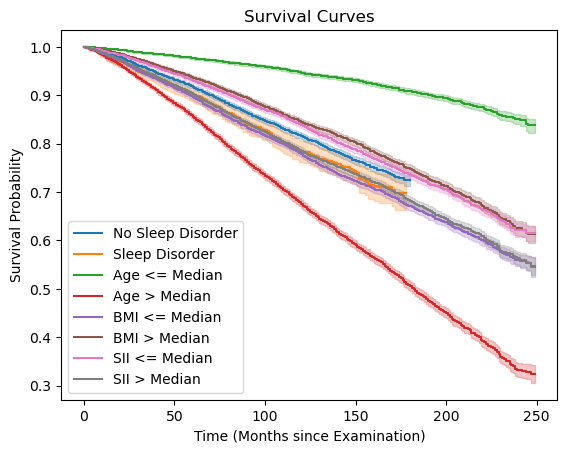

In [493]:
import pandas as pd
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
kmf.fit(df['permth_exm'][df['sleep_disorder'] == 'No'], df['mort_stat'][df['sleep_disorder'] == 'No'], label='No Sleep Disorder')
kmf.plot(ci_show=True) 


kmf.fit(df['permth_exm'][df['sleep_disorder'] == 'Yes'], df['mort_stat'][df['sleep_disorder'] == 'Yes'], label='Sleep Disorder')
kmf.plot(ci_show=True)  

median_age = df['age'].median() 
kmf.fit(df['permth_exm'][df['age'] <= median_age], df['mort_stat'][df['age'] <= median_age], label='Age <= Median')
kmf.plot(ci_show=True) 

kmf.fit(df['permth_exm'][df['age'] > median_age], df['mort_stat'][df['age'] > median_age], label='Age > Median')
kmf.plot(ci_show=True)  


median_bmi = df['bmi'].median()  
kmf.fit(df['permth_exm'][df['bmi'] <= median_bmi], df['mort_stat'][df['bmi'] <= median_bmi], label='BMI <= Median')
kmf.plot(ci_show=True)  

kmf.fit(df['permth_exm'][df['bmi'] > median_bmi], df['mort_stat'][df['bmi'] > median_bmi], label='BMI > Median')
kmf.plot(ci_show=True)  


median_bmi = df['SII'].median()  
kmf.fit(df['permth_exm'][df['SII'] <= median_bmi], df['mort_stat'][df['SII'] <= median_bmi], label='SII <= Median')
kmf.plot(ci_show=True) 

kmf.fit(df['permth_exm'][df['SII'] > median_bmi], df['mort_stat'][df['SII'] > median_bmi], label='SII > Median')
kmf.plot(ci_show=True) 

plt.xlabel('Time (Months since Examination)')
plt.ylabel('Survival Probability')
plt.title('Survival Curves')
plt.show()


In [504]:
df['sleep_disorder'].fillna(df['sleep_disorder'].mode()[0], inplace=True)

In [559]:
cph = CoxPHFitter()
cph.fit(df, duration_col='permth_exm', event_col='mort_stat', formula='sleep_disorder + SII_Group + age + bmi + education_level + race + smoking_status + alcohol_drinking_status + physical_activity_classification')

<lifelines.CoxPHFitter: fitted with 28571 total observations, 20594 right-censored observations>

In [560]:
(cph.summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
sleep_disorder[T.No],-0.245620,0.782220,0.057312,-0.357950,-0.133289,0.699108,0.875212,0.0,-4.285625,1.822264e-05,15.743908
SII_Group[T.Middle],-0.066435,0.935724,0.038255,-0.141413,0.008543,0.868131,1.008579,0.0,-1.736650,8.244898e-02,3.600355
SII_Group[T.High],0.135921,1.145592,0.032582,0.072062,0.199780,1.074722,1.221134,0.0,4.171698,3.023382e-05,15.013477
age,0.094136,1.098709,0.001117,0.091947,0.096325,1.096307,1.101117,0.0,84.298630,0.000000e+00,inf
bmi,-0.006832,0.993192,0.000941,-0.008675,-0.004988,0.991362,0.995024,0.0,-7.263828,3.762875e-13,41.273230
education_level[T.college or above],-0.111938,0.894100,0.032535,-0.175705,-0.048171,0.838865,0.952971,0.0,-3.440556,5.805201e-04,10.750366
education_level[T.high school],0.008288,1.008322,0.037178,-0.064579,0.081155,0.937462,1.084539,0.0,0.222928,8.235914e-01,0.279999
race[T.Non-Hispanic Black],0.407427,1.502945,0.042228,0.324661,0.490193,1.383561,1.632631,0.0,9.648175,5.003810e-22,70.759391
race[T.Non-Hispanic White],0.231653,1.260682,0.036574,0.159969,0.303337,1.173474,1.354371,0.0,6.333791,2.392090e-10,31.961009


In [561]:
print('HR for "High" SII_Group:', cph.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])

print("\n")
print('HR for "Middle" SII_Group:', cph.summary.loc['SII_Group[T.Middle]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph.summary.loc['SII_Group[T.Middle]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph.summary.loc['SII_Group[T.Middle]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.1455915894809512
Lower bound of 95% CI for HR: 1.0747221260761697
Upper bound of 95% CI for HR: 1.2211343360734705


HR for "Middle" SII_Group: 0.9357235847927641
Lower bound of 95% CI for HR: 0.8681305664715043
Upper bound of 95% CI for HR: 1.0085794245169704


In [562]:
import numpy as np
sleep_disorder = cph.summary.loc['sleep_disorder[T.No]', 'coef']
print("Coef sleep_disorder", sleep_disorder)

HR = np.exp(sleep_disorder)

print("(HR) =  exp({:.3f}) = ".format(sleep_disorder), HR)

percentage_reduction = (HR - 1) * 100

print("Percentage reduction:", percentage_reduction, "%")

Coef sleep_disorder -0.2456195754033349
(HR) =  exp(-0.246) =  0.7822197439607094
Percentage reduction: -21.778025603929063 %


In [563]:
cph_cancer = CoxPHFitter()

cph_cancer.fit(
    df[(df['ucod_leading'] == 'Malignant neoplasms')], 
    duration_col='permth_exm', 
    event_col='mort_stat', 
    formula='sleep_disorder + SII_Group + age + bmi + education_level + race + smoking_status + alcohol_drinking_status + physical_activity_classification'
)


print('HR for "High" SII_Group:', cph_cancer.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_cancer.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_cancer.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])
print("\n")
print('HR for "Middle" SII_Group:', cph_cancer.summary.loc['SII_Group[T.Middle]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_cancer.summary.loc['SII_Group[T.Middle]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_cancer.summary.loc['SII_Group[T.Middle]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 0.9714492624449514
Lower bound of 95% CI for HR: 0.8551846943039706
Upper bound of 95% CI for HR: 1.1035202989372053


HR for "Middle" SII_Group: 0.9207828873384359
Lower bound of 95% CI for HR: 0.7915995953167354
Upper bound of 95% CI for HR: 1.071047952312391


In [555]:
cph_heart_disease = CoxPHFitter()

cph_heart_disease.fit(
    df[(df['ucod_leading'] == 'Diseases of heart') | (df['ucod_leading'] == 'Cerebrovascular disease')], 
    duration_col='permth_exm', 
    event_col='mort_stat', 
    formula='sleep_disorder + SII_Group + age + bmi + education_level + race + smoking_status + alcohol_drinking_status + physical_activity_classification'
)


print('HR for "High" SII_Group:', cph_heart_disease.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_heart_disease.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_heart_disease.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])
print("\n")
print('HR for "Middle" SII_Group:', cph_heart_disease.summary.loc['SII_Group[T.Middle]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_heart_disease.summary.loc['SII_Group[T.Middle]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_heart_disease.summary.loc['SII_Group[T.Middle]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.0814341271238435
Lower bound of 95% CI for HR: 0.959350012870705
Upper bound of 95% CI for HR: 1.2190543134601768


HR for "Middle" SII_Group: 1.0010599137974403
Lower bound of 95% CI for HR: 0.8730062296074373
Upper bound of 95% CI for HR: 1.1478966781975426


In [554]:

df['event'] = (df['ucod_leading'] == 'All other causes (residual)').astype(int)

cph_other_causes = CoxPHFitter()
cph_other_causes.fit(
    df, 
    duration_col='permth_exm', 
    event_col='event', 
    formula='sleep_disorder + SII_Group + age + bmi + education_level + race + smoking_status + alcohol_drinking_status + physical_activity_classification'
)

print('HR for "High" SII_Group:', cph_other_causes.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_other_causes.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_other_causes.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])
print("\n")
print('HR for "Middle" SII_Group:', cph_other_causes.summary.loc['SII_Group[T.Middle]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_other_causes.summary.loc['SII_Group[T.Middle]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_other_causes.summary.loc['SII_Group[T.Middle]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.0585894666369007
Lower bound of 95% CI for HR: 0.9359687389638103
Upper bound of 95% CI for HR: 1.197274665514151


HR for "Middle" SII_Group: 0.8093030182063428
Lower bound of 95% CI for HR: 0.697830908140226
Upper bound of 95% CI for HR: 0.9385817791066979


In [553]:
cph_1 = CoxPHFitter()
cph_1.fit(df, duration_col='permth_exm', event_col='mort_stat', formula='sleep_disorder + SII_Group')

print('HR for "High" SII_Group:', cph_1.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_1.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_1.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])
print("\n")
print('HR for "Middle" SII_Group:', cph_1.summary.loc['SII_Group[T.Middle]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_1.summary.loc['SII_Group[T.Middle]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_1.summary.loc['SII_Group[T.Middle]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.1525798556671918
Lower bound of 95% CI for HR: 1.083190935328453
Upper bound of 95% CI for HR: 1.226413811602832


HR for "Middle" SII_Group: 0.8659106262522038
Lower bound of 95% CI for HR: 0.8038949524558169
Upper bound of 95% CI for HR: 0.9327104373101458


In [552]:
cph_heart_disease_1 = CoxPHFitter()

cph_heart_disease_1.fit(
    df[(df['ucod_leading'] == 'Diseases of heart') | (df['ucod_leading'] == 'Cerebrovascular disease')], 
    duration_col='permth_exm', 
    event_col='mort_stat', 
    formula='sleep_disorder + SII_Group '
)


print('HR for "High" SII_Group:', cph_heart_disease_1.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_heart_disease_1.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_heart_disease_1.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])
print("\n")
print('HR for "Middle" SII_Group:', cph_heart_disease_1.summary.loc['SII_Group[T.Middle]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_heart_disease_1.summary.loc['SII_Group[T.Middle]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_heart_disease_1.summary.loc['SII_Group[T.Middle]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.0949990487859693
Lower bound of 95% CI for HR: 0.974749021589897
Upper bound of 95% CI for HR: 1.2300837346689217


HR for "Middle" SII_Group: 1.0032260079908264
Lower bound of 95% CI for HR: 0.8764253608746456
Upper bound of 95% CI for HR: 1.1483720896720642


In [551]:
cph_cancer_1 = CoxPHFitter()

cph_cancer_1.fit(
    df[(df['ucod_leading'] == 'Malignant neoplasms')], 
    duration_col='permth_exm', 
    event_col='mort_stat', 
    formula='sleep_disorder + SII_Group'
)


print('HR for "High" SII_Group:', cph_cancer_1.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_cancer_1.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_cancer_1.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])
print("\n")
print('HR for "Middle" SII_Group:', cph_cancer_1.summary.loc['SII_Group[T.Middle]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_cancer_1.summary.loc['SII_Group[T.Middle]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_cancer_1.summary.loc['SII_Group[T.Middle]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 0.9252564007309879
Lower bound of 95% CI for HR: 0.8168573910024093
Upper bound of 95% CI for HR: 1.048040228959791


HR for "Middle" SII_Group: 0.8070864316105302
Lower bound of 95% CI for HR: 0.6953295822629225
Upper bound of 95% CI for HR: 0.9368054009292989


In [550]:

df['event'] = (df['ucod_leading'] == 'All other causes (residual)').astype(int)

cph_other_causes_1 = CoxPHFitter()
cph_other_causes_1.fit(
    df, 
    duration_col='permth_exm', 
    event_col='event', 
    formula='sleep_disorder + SII_Group'
)

print('HR for "High" SII_Group:', cph_other_causes_1.summary.loc['SII_Group[T.High]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_other_causes_1.summary.loc['SII_Group[T.High]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_other_causes_1.summary.loc['SII_Group[T.High]', 'exp(coef) upper 95%'])
print("\n")
print('HR for "Middle" SII_Group:', cph_other_causes_1.summary.loc['SII_Group[T.Middle]', 'exp(coef)'])
print('Lower bound of 95% CI for HR:', cph_other_causes_1.summary.loc['SII_Group[T.Middle]', 'exp(coef) lower 95%'])
print('Upper bound of 95% CI for HR:', cph_other_causes_1.summary.loc['SII_Group[T.Middle]', 'exp(coef) upper 95%'])

HR for "High" SII_Group: 1.0449856190105562
Lower bound of 95% CI for HR: 0.9272409439908584
Upper bound of 95% CI for HR: 1.1776819725398593


HR for "Middle" SII_Group: 0.7387282357906318
Lower bound of 95% CI for HR: 0.6378121288238937
Upper bound of 95% CI for HR: 0.855611522096059
